In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [23]:
"""
# This script performs the following main tasks:
# 1. Load corrected stride data for multiple participants and concatenate the data.
# 2. After concatenation, re-evaluate stride correctness by checking correlations against the mean trace.
# 3. Save the concatenated and corrected stride data into a single file for further analysis.
# 4. Plot all concatenated strides per header, including visualising the mean stride and the average event positions.

# The structure of the saved concatenated data is as follows:
# - concatenated_data (dict): A dictionary containing data for each header (e.g., pelvis_tilt, hip_flexion_r, etc.).
# - Each header (dict): Contains two keys, 'strides_r' and 'strides_l', representing right and left strides.
# - Each 'strides_r' or 'strides_l' is a list of dictionaries.
#   - Each dictionary contains:
#     - 'corrected_stride_data' (ndarray): The stride data of length 100 after potential correction.
#     - 'normalized_events' (list): A list of events associated with that stride, containing the normalized index positions and event types.
"""

"\n# This script performs the following main tasks:\n# 1. Load corrected stride data for multiple participants and concatenate the data.\n# 2. After concatenation, re-evaluate stride correctness by checking correlations against the mean trace.\n# 3. Save the concatenated and corrected stride data into a single file for further analysis.\n# 4. Plot all concatenated strides per header, including visualising the mean stride and the average event positions.\n\n# The structure of the saved concatenated data is as follows:\n# - concatenated_data (dict): A dictionary containing data for each header (e.g., pelvis_tilt, hip_flexion_r, etc.).\n# - Each header (dict): Contains two keys, 'strides_r' and 'strides_l', representing right and left strides.\n# - Each 'strides_r' or 'strides_l' is a list of dictionaries.\n#   - Each dictionary contains:\n#     - 'corrected_stride_data' (ndarray): The stride data of length 100 after potential correction.\n#     - 'normalized_events' (list): A list of eve

In [24]:
# File path for the corrected data
corrected_data_folder = r'F:\AlterG\IndividualKinematics'
concatenated_data_file = r'F:\AlterG\NormHealthyData\Kinematics.pkl'
# Create directory if it doesn't exist
os.makedirs(os.path.dirname(concatenated_data_file), exist_ok=True)

In [25]:
# Function to load corrected participant data
def load_corrected_participant_data(participant_number, corrected_data_folder):
    corrected_file_path = os.path.join(corrected_data_folder, f"{participant_number:02d}_corrected.pkl")
    if os.path.exists(corrected_file_path):
        with open(corrected_file_path, 'rb') as f:
            corrected_data = pickle.load(f)
            return corrected_data
    else:
        print(f"Corrected data file for Participant {participant_number} not found.")
        return None

In [26]:
# Function to concatenate strides and events from all participants
def concatenate_all_participants(participant_numbers, corrected_data_folder):
    concatenated_data = {}
    
    # Iterate through all participants
    for participant_number in participant_numbers:
        corrected_data = load_corrected_participant_data(participant_number, corrected_data_folder)
        if corrected_data is None:
            continue
        
        # Iterate through each header and concatenate corrected_stride_data and normalized_events
        for header, strides in corrected_data.items():
            if header not in concatenated_data:
                concatenated_data[header] = {
                    'strides_r': [],
                    'strides_l': []
                }
                
            for side in ['strides_r', 'strides_l']:
                side_strides = strides.get(side, [])
                for stride in side_strides:
                    if 'corrected_stride_data' in stride and 'normalized_events' in stride:
                        concatenated_data[header][side].append({
                            'corrected_stride_data': stride['corrected_stride_data'],
                            'normalized_events': stride['normalized_events']
                        })
    
    # Perform correction based on correlation after concatenation
    for header, data in concatenated_data.items():
        for side in ['strides_r', 'strides_l']:
            all_strides = np.array([entry['corrected_stride_data'] for entry in data[side]])
            if all_strides.size > 0:
                mean_trace = np.mean(all_strides, axis=0)
                corrected_strides = []
                
                # Iterate through each stride and perform correction based on correlation
                for entry in data[side]:
                    stride = entry['corrected_stride_data']
                    correlation = np.corrcoef(stride, mean_trace)[0, 1]
                    flipped_correlation = np.corrcoef(-stride, mean_trace)[0, 1]
                    if flipped_correlation > correlation:
                        entry['corrected_stride_data'] = -stride
                    corrected_strides.append(entry)
                
                # Update the corrected strides in the concatenated data
                concatenated_data[header][side] = corrected_strides
    
    return concatenated_data

In [27]:
# Function to save concatenated data
def save_concatenated_data(concatenated_data, output_file):
    with open(output_file, 'wb') as f:
        pickle.dump(concatenated_data, f)
    print(f"Concatenated data saved to {output_file}")


In [28]:
# Function to plot concatenated data
def plot_concatenated_data(concatenated_data):
    # Plotting concatenated data for each header
    for header, data in concatenated_data.items():
        # Print number of strides and corresponding header and side information
        num_strides_r = len(data['strides_r']['corrected_stride_data'])
        num_strides_l = len(data['strides_l']['corrected_stride_data'])
        print(f"Header: {header} - Right Strides: {num_strides_r}, Left Strides: {num_strides_l}")
        
        plt.figure(figsize=(10, 6))
        all_strides_r = np.array(data['strides_r']['corrected_stride_data'])
        all_strides_l = np.array(data['strides_l']['corrected_stride_data'])
        mean_stride_r = np.mean(all_strides_r, axis=0) if all_strides_r.size > 0 else None
        mean_stride_l = np.mean(all_strides_l, axis=0) if all_strides_l.size > 0 else None
        
        # Plot all right strides
        if all_strides_r.size > 0:
            for stride in all_strides_r:
                plt.plot(stride, color='gray', alpha=0.3)
            plt.plot(mean_stride_r, color='blue', linewidth=2, label='Mean Right Stride')
        
        # Plot all left strides
        if all_strides_l.size > 0:
            for stride in all_strides_l:
                plt.plot(stride, color='gray', alpha=0.3)
            plt.plot(mean_stride_l, color='red', linewidth=2, label='Mean Left Stride')
        
        # Plotting mean events as vertical lines
        all_events_r = data['strides_r']['normalized_events']
        all_events_l = data['strides_l']['normalized_events']
        
        if len(all_events_r) > 0:
            mean_events_r = np.mean([event['index'] for event in all_events_r])
            plt.axvline(mean_events_r, color='blue', linestyle='--', label='Mean Right Event', alpha=0.8)
        
        if len(all_events_l) > 0:
            mean_events_l = np.mean([event['index'] for event in all_events_l])
            plt.axvline(mean_events_l, color='red', linestyle='--', label='Mean Left Event', alpha=0.8)
        
        plt.title(f"Concatenated Data for Header: {header}")
        plt.xlabel("Time (Normalized)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.show()

Concatenated data file already exists at F:\AlterG\NormHealthyData\Kinematics.pkl, loading the data...
Header: pelvis_tilt - Right Strides: 1095, Left Strides: 1090


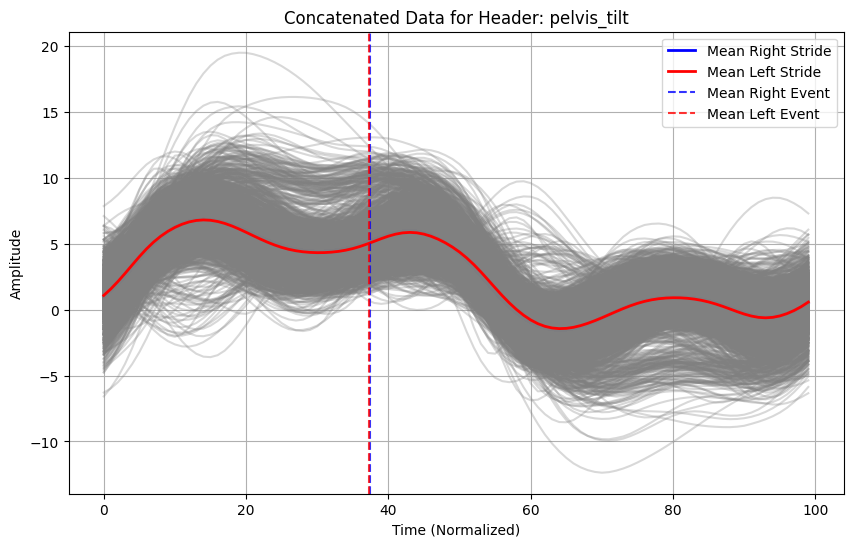

Header: pelvis_list - Right Strides: 1095, Left Strides: 1090


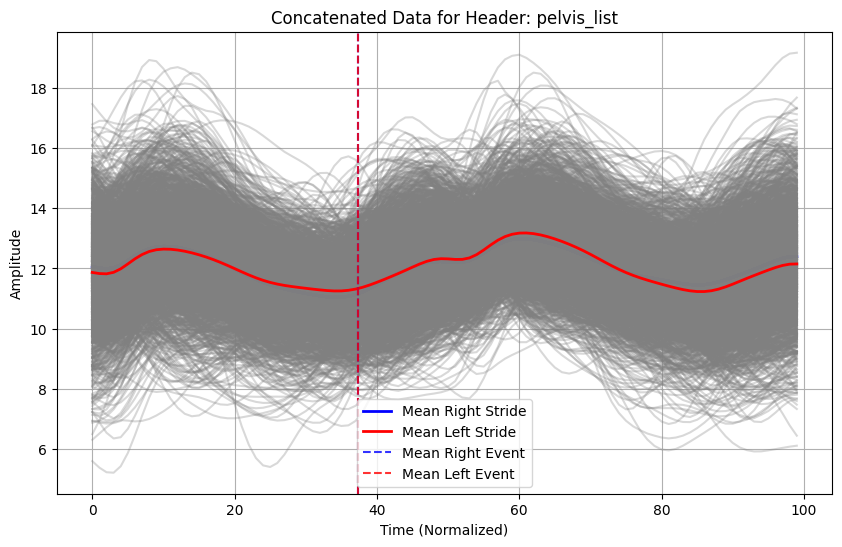

Header: pelvis_rotation - Right Strides: 1095, Left Strides: 1090


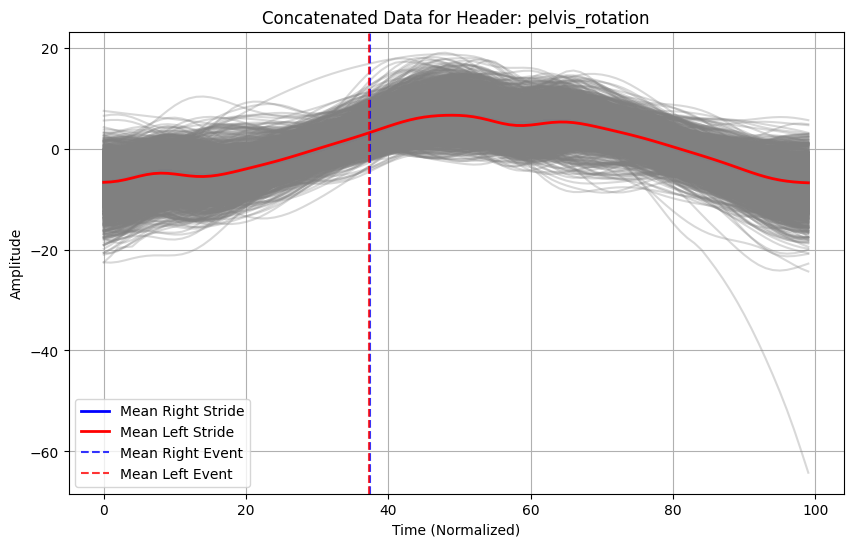

Header: pelvis_tx - Right Strides: 1095, Left Strides: 1090


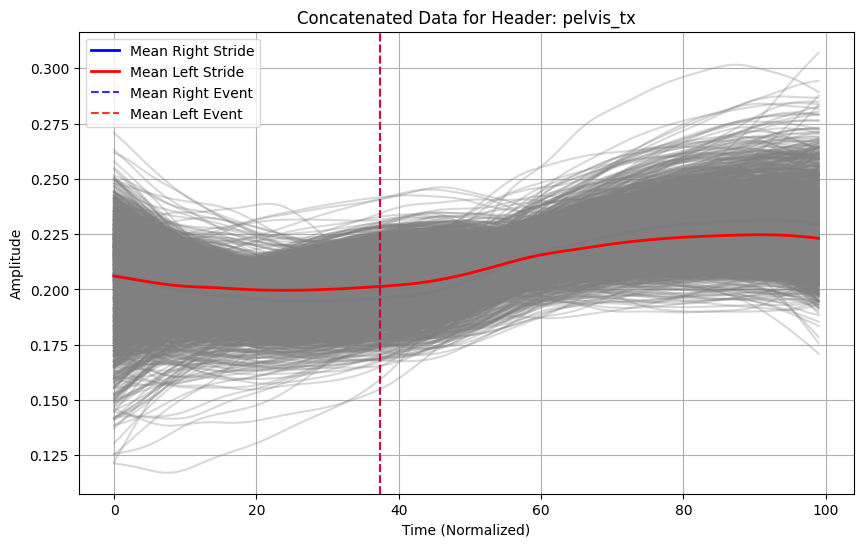

Header: pelvis_ty - Right Strides: 1095, Left Strides: 1090


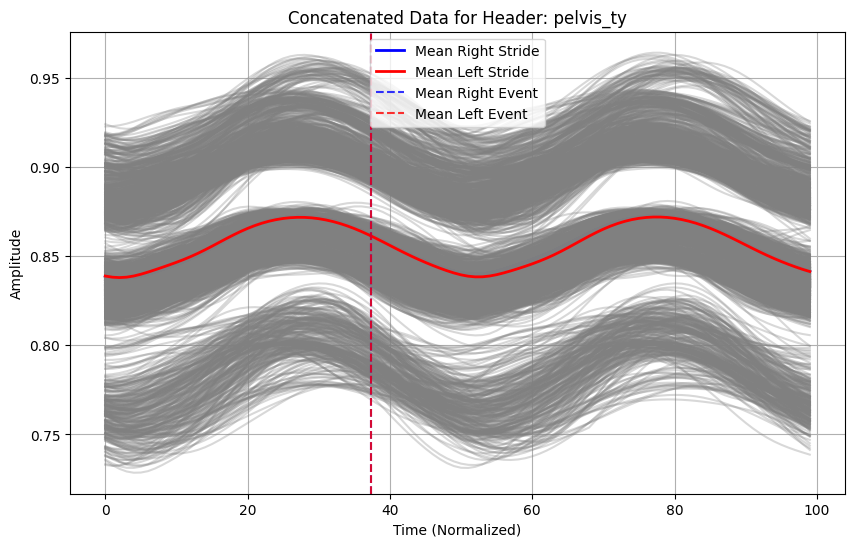

Header: pelvis_tz - Right Strides: 1095, Left Strides: 1090


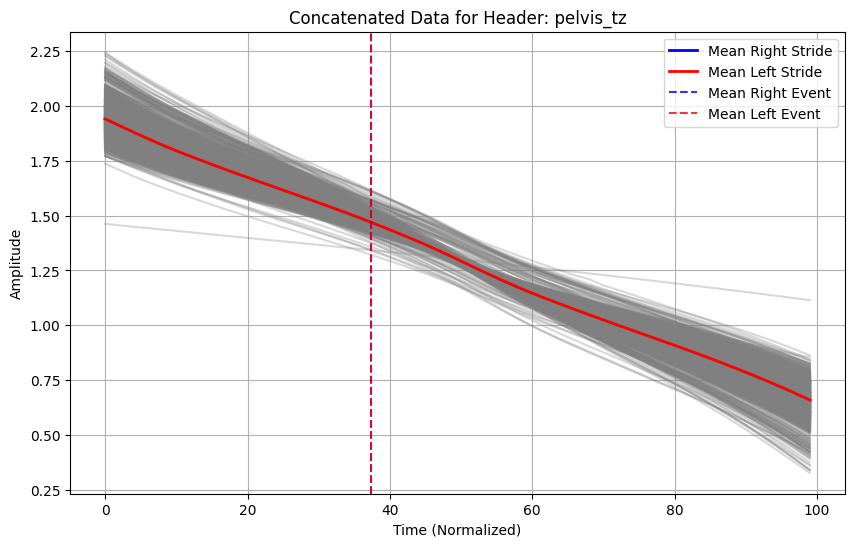

Header: lumbar_extension - Right Strides: 1095, Left Strides: 1090


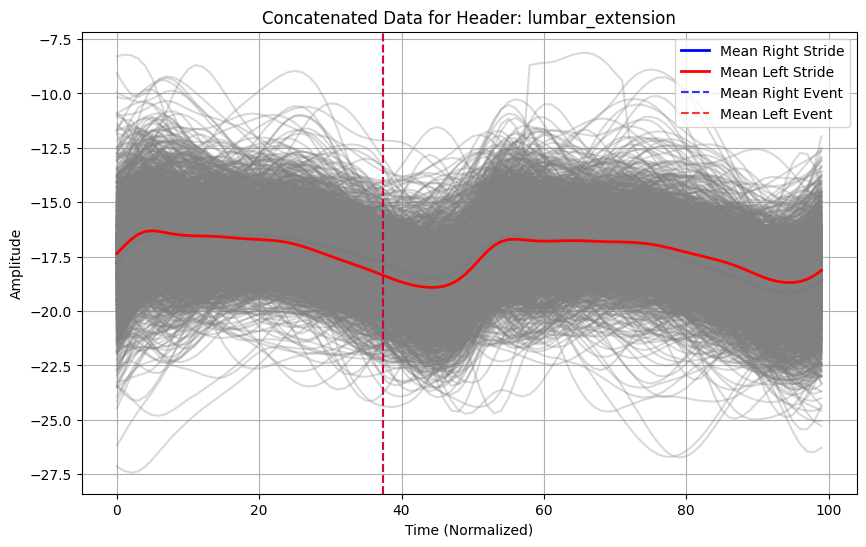

Header: lumbar_bending - Right Strides: 1095, Left Strides: 1090


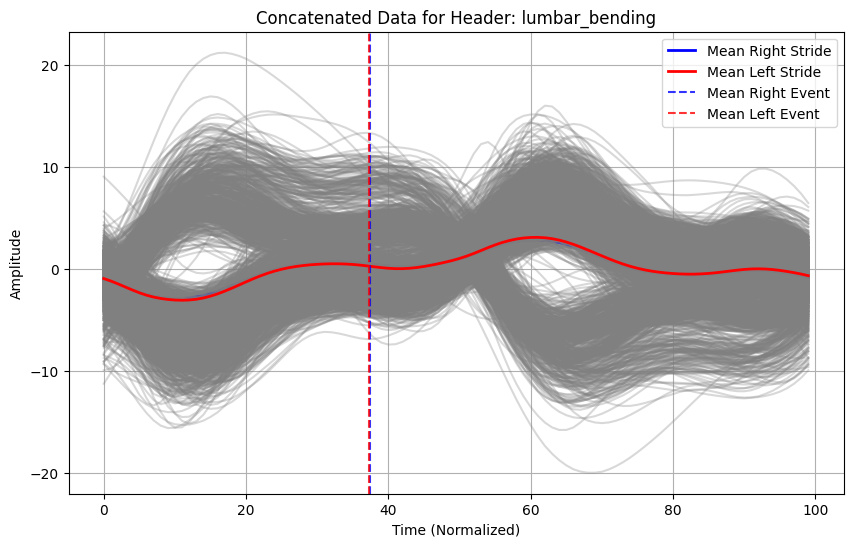

Header: lumbar_rotation - Right Strides: 1095, Left Strides: 1090


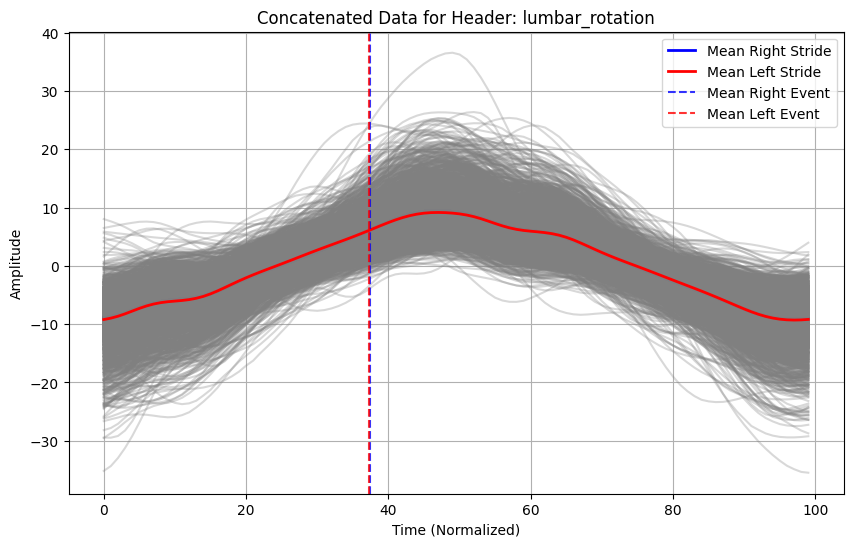

Header: hip_flexion_r - Right Strides: 1095, Left Strides: 0


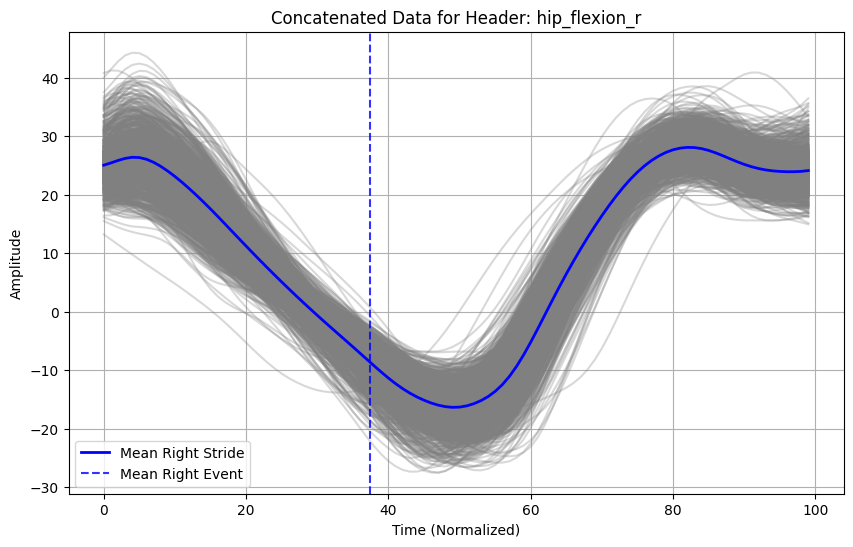

Header: hip_adduction_r - Right Strides: 1095, Left Strides: 0


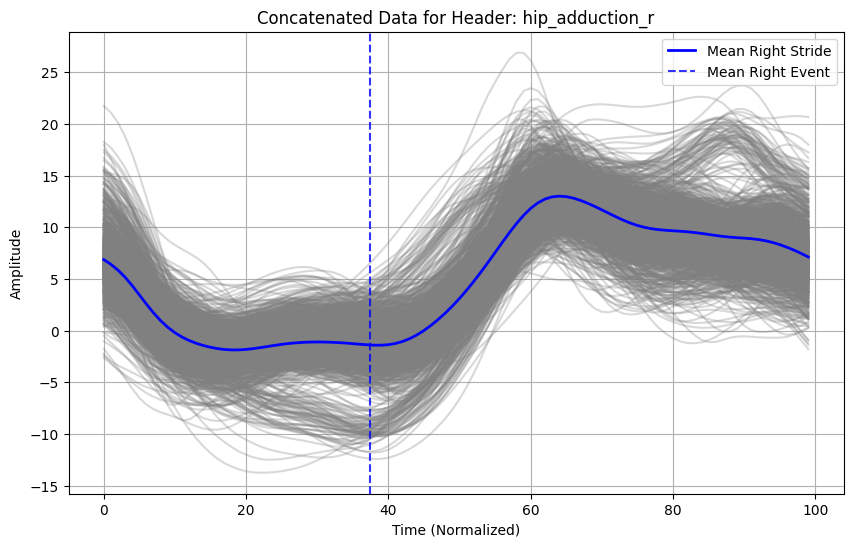

Header: hip_rotation_r - Right Strides: 1095, Left Strides: 0


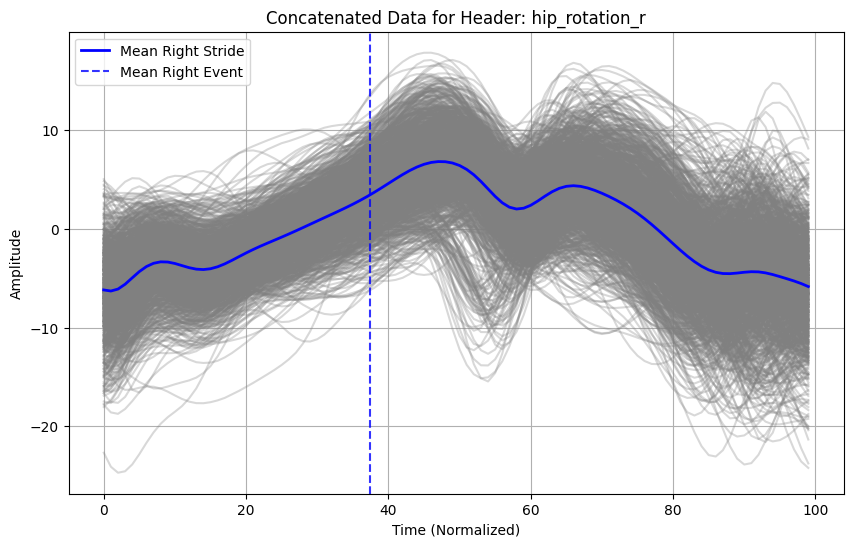

Header: knee_angle_r - Right Strides: 1095, Left Strides: 0


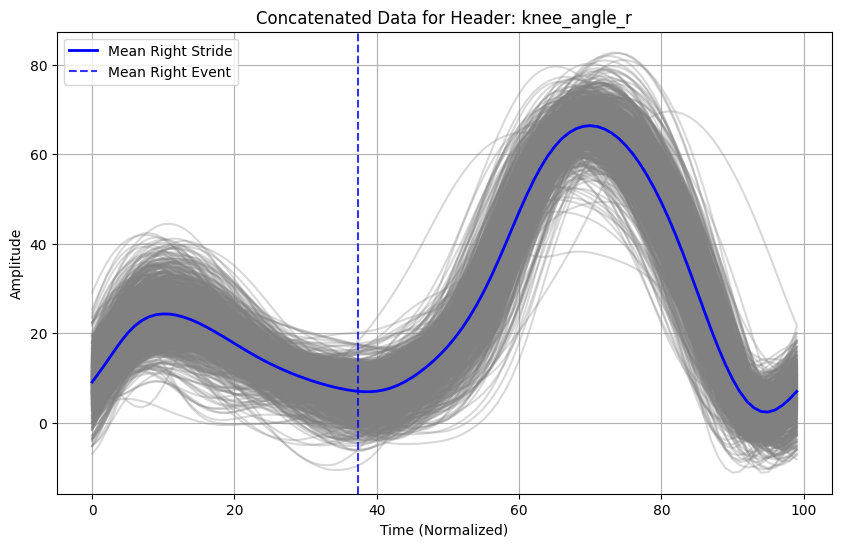

Header: ankle_angle_r - Right Strides: 1095, Left Strides: 0


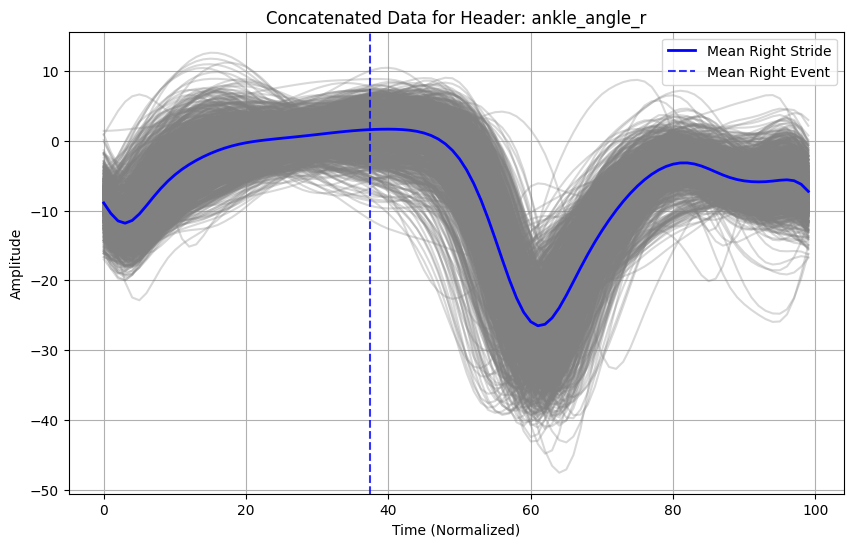

Header: subtalar_angle_r - Right Strides: 1095, Left Strides: 0


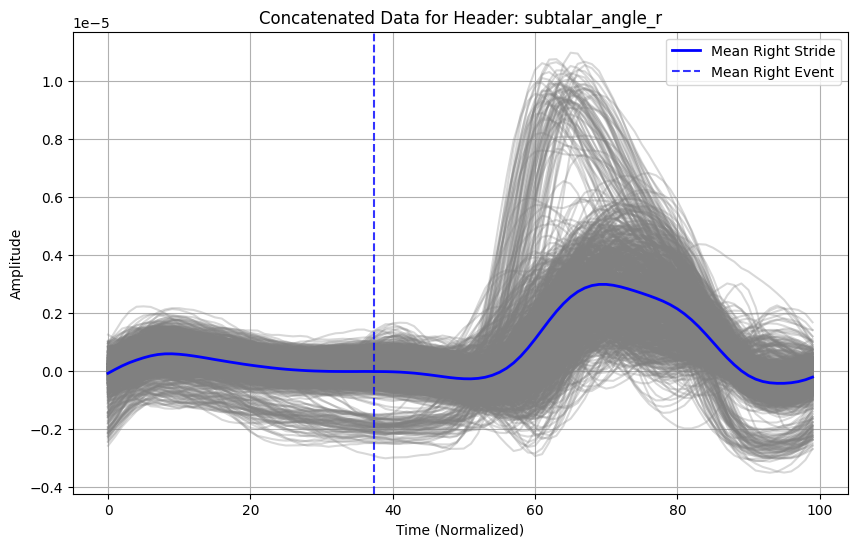

Header: mtp_angle_r - Right Strides: 1095, Left Strides: 0


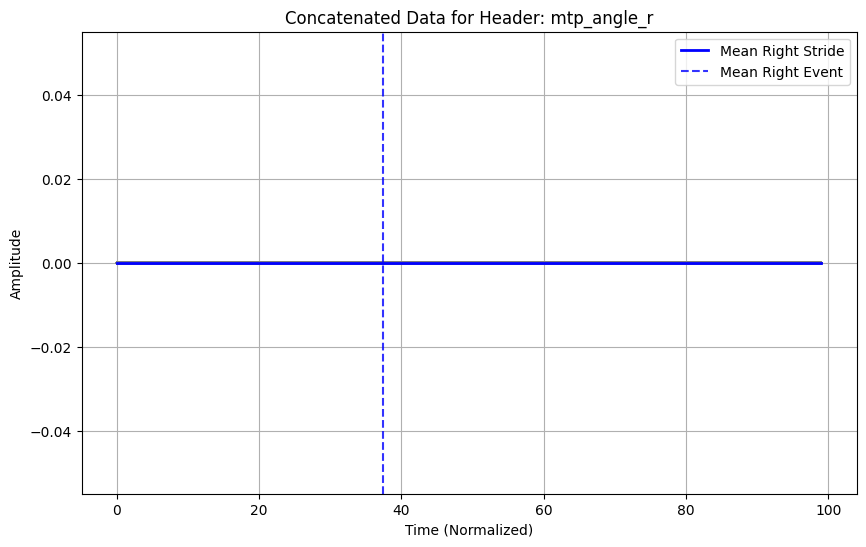

Header: hip_flexion_l - Right Strides: 0, Left Strides: 1090


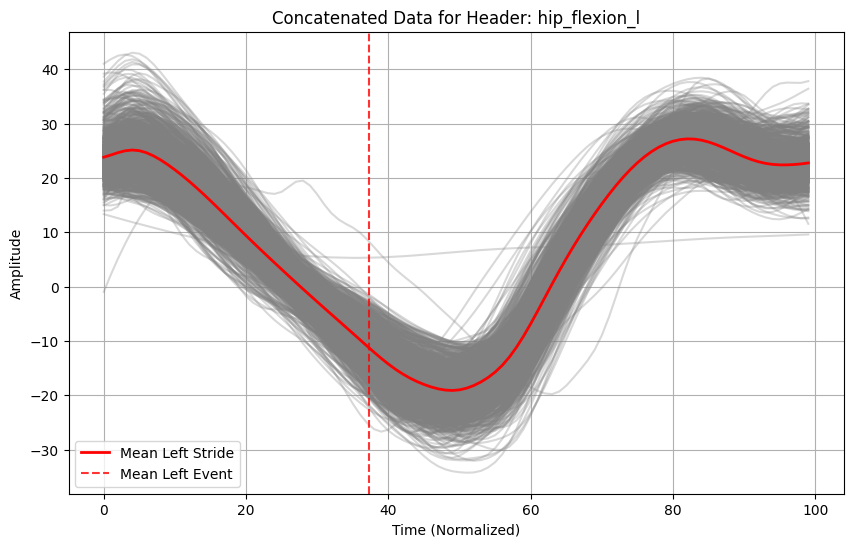

Header: hip_adduction_l - Right Strides: 0, Left Strides: 1090


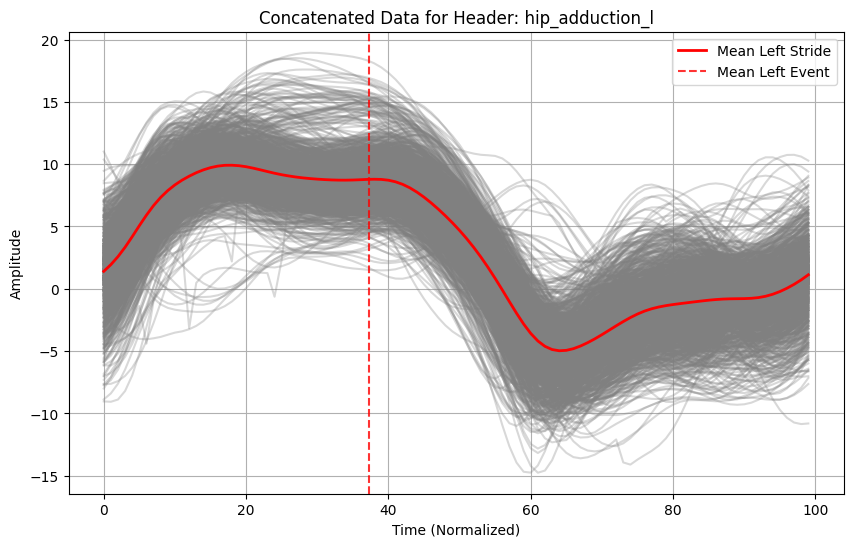

Header: hip_rotation_l - Right Strides: 0, Left Strides: 1090


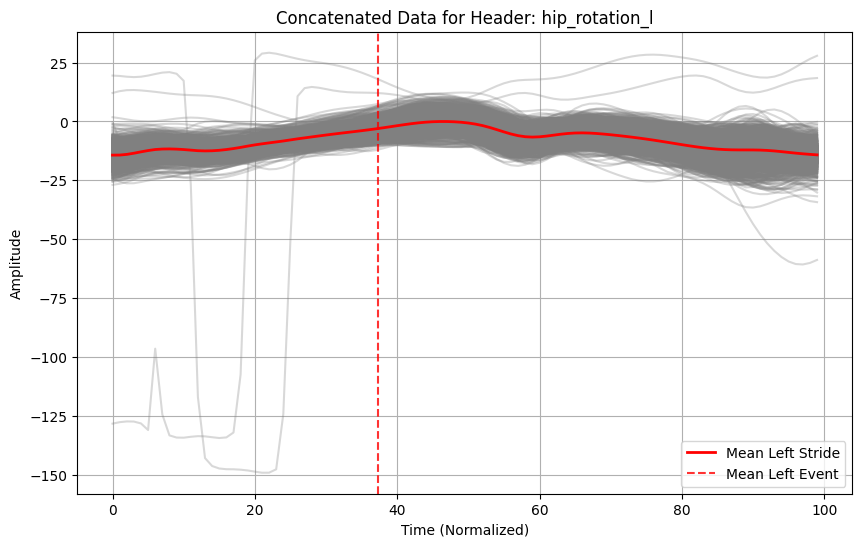

Header: knee_angle_l - Right Strides: 0, Left Strides: 1090


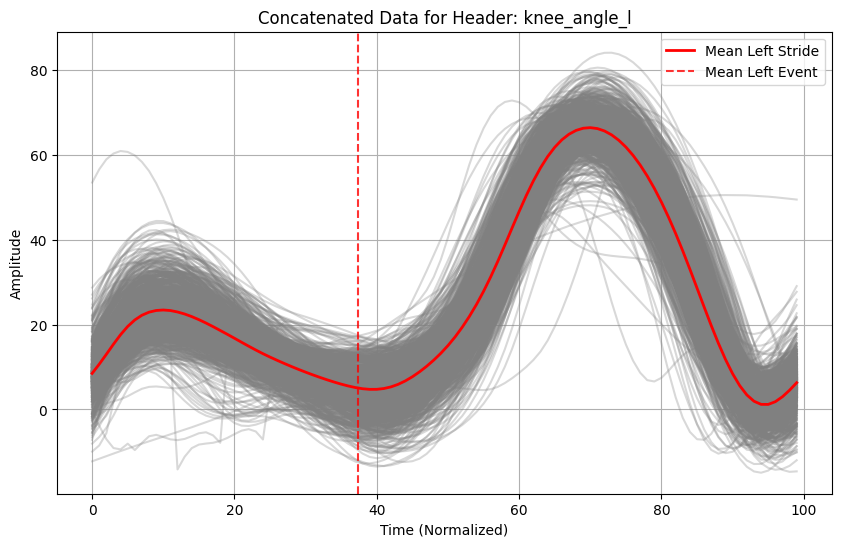

Header: ankle_angle_l - Right Strides: 0, Left Strides: 1090


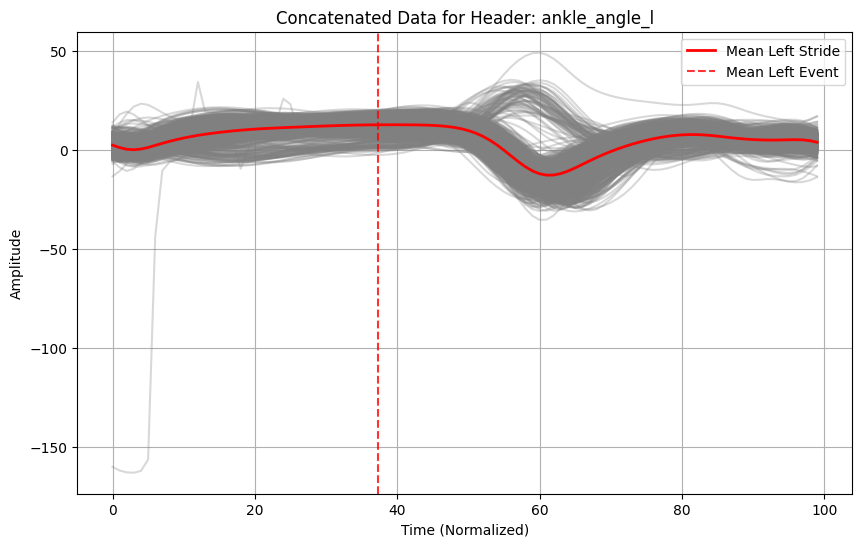

Header: subtalar_angle_l - Right Strides: 0, Left Strides: 1090


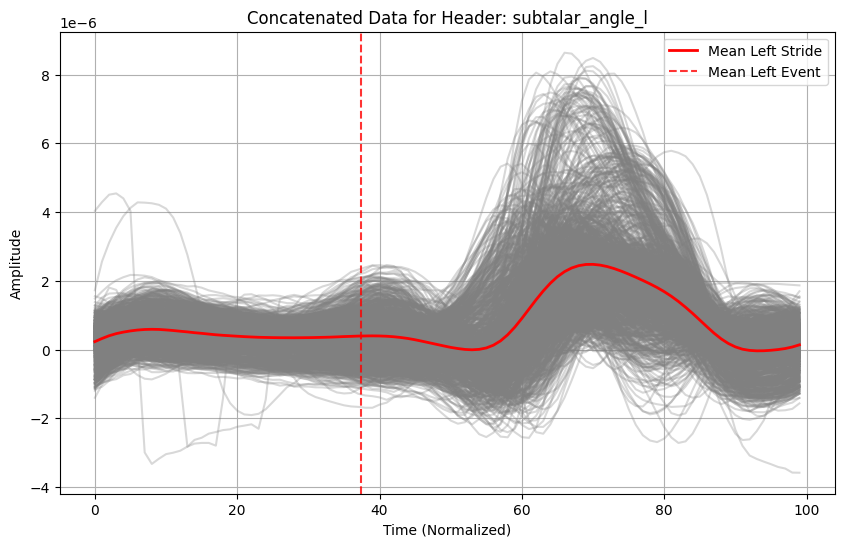

Header: mtp_angle_l - Right Strides: 0, Left Strides: 1090


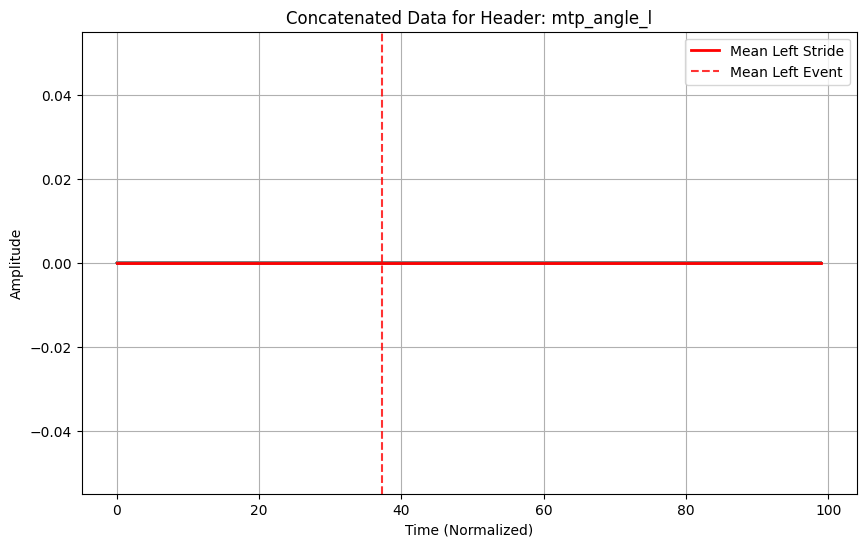

In [29]:
if os.path.exists(concatenated_data_file):
    print(f"Concatenated data file already exists at {concatenated_data_file}, loading the data...")
    with open(concatenated_data_file, 'rb') as f:
        concatenated_data = pickle.load(f)
else:
    participant_numbers = range(1, 22)  # Assuming 21 participants
    concatenated_data = concatenate_all_participants(participant_numbers, corrected_data_folder)
    # Save concatenated data
    save_concatenated_data(concatenated_data, concatenated_data_file)

# Plotting concatenated data for each header
plot_concatenated_data(concatenated_data)